# 카페블랑

In [16]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException
import pandas as pd
import time

# ChromeDriver 옵션 설정
options = webdriver.ChromeOptions()
options.add_argument("--disable-gpu")
options.add_argument("--window-size=2560,1440")
options.add_experimental_option("excludeSwitches", ["enable-logging", "enable-automation"])
options.add_argument("--disable-blink-features=AutomationControlled")

# ChromeDriver 초기화
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)

# 네이버 지도 페이지로 이동
driver.get('https://map.naver.com/p/search/카페블랑131/place/1214592701?c=15.00,0,0,0,dh&isCorrectAnswer=true')

# 페이지 로드 대기
WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.ID, "entryIframe")))

try:
    # entryIframe이 로드될 때까지 대기 후 전환
    WebDriverWait(driver, 10).until(EC.frame_to_be_available_and_switch_to_it((By.ID, "entryIframe")))

    # 가게 이름 검색
    store_name_element = WebDriverWait(driver, 15).until(
        EC.presence_of_element_located((By.XPATH, "//*[@id='_title']/div/span[1]"))
    )
    store_name = store_name_element.text

    # 업종 카테고리 검색
    category_element = WebDriverWait(driver, 15).until(
        EC.presence_of_element_located((By.XPATH, "//*[@id='_title']/div/span[2]"))
    )
    category = category_element.text

    # 별점 검색 (없으면 "없음" 출력)
    rating = "없음"
    try:
        rating_element = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.XPATH, "/html/body/div[3]/div/div/div/div[2]/div[1]/div[2]/span[1]"))
        )
        rating_text = rating_element.text
        rating = rating_text.replace("별점", "").strip()
    except (NoSuchElementException, TimeoutException):
        rating = "없음"

    # 방문자 리뷰 검색 (없으면 "없음" 출력)
    try:
        visitor_review_element = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.XPATH, "//*[@id='app-root']/div/div/div/div[2]/div[1]/div[2]/span[2]/a"))
        )
        visitor_review = visitor_review_element.text.split("리뷰")[1].strip()
    except (NoSuchElementException, TimeoutException):
        visitor_review = "없음"

    # 블로그 리뷰 검색 (없으면 "없음" 출력)
    try:
        blog_review_element = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.XPATH, "//*[@id='app-root']/div/div/div/div[2]/div[1]/div[2]/span[3]/a"))
        )
        blog_review = blog_review_element.text.split("리뷰")[1].strip()
    except (NoSuchElementException, TimeoutException):
        blog_review = "없음"

    # 결과 출력
    print(f"가게 이름: {store_name}")
    print(f"업종 카테고리: {category}")
    print(f"별점: {rating}\n")
    print(f"방문자 리뷰: {visitor_review}")
    print(f"블로그 리뷰: {blog_review}\n")


    # '리뷰' 탭 클릭하기
    review_tab_element = WebDriverWait(driver, 15).until(
        EC.element_to_be_clickable((By.XPATH, "//span[text()='리뷰']"))
    )
    review_tab_element.click()
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//*[@id="app-root"]/div/div/div/div[6]/div[3]/div[3]/h2/div[1]/em'))
    )
    print("리뷰 탭 클릭 완료")

    # 리뷰 총 개수 가져오기
    review_count_element = WebDriverWait(driver, 20).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, "#app-root > div > div > div > div:nth-child(6) > div:nth-child(3) > div.place_section.k1QQ5 > h2 > div.place_section_header_title > em.place_section_count"))
    )
    total_reviews = int(review_count_element.text.replace(',', ''))
    print("총 리뷰 수:", total_reviews)
    print('\n')
    total_reviews = min(total_reviews, 1000)  # 최대 1000개의 리뷰로 제한

    reviews = []
    review_text_set = set()
    retry_count = 0
    max_retries = 3

    # '더보기' 버튼이 없어질 때까지 리뷰 수집
    while len(reviews) < total_reviews and retry_count < max_retries:
        review_elements = driver.find_elements(By.XPATH, '//*[@id="app-root"]/div/div/div/div[6]/div[3]/div[3]/div/ul/li')
        loaded_review_count = len(review_elements)
        print(f"로드된 리뷰 개수: {loaded_review_count}, 수집된 리뷰 개수: {len(reviews)}")

        if loaded_review_count > len(reviews):
            retry_count = 0  # 새로운 리뷰가 로드되면 리트라이 카운트 초기화
            for review_element in review_elements[len(reviews):]:
                try:
                    # 작성자 이름
                    try:
                        author_name = review_element.find_element(By.XPATH, './/div[1]/a[2]/div[1]/span/span').text.strip()
                    except NoSuchElementException:
                        author_name = "Unknown"

                    # 리뷰 개수
                    try:
                        review_count_text = review_element.find_element(By.XPATH, './/div[1]/a[2]/div[2]/span[2]').text.strip()
                    except NoSuchElementException:
                        review_count_text = "Unknown"

                    # 리뷰 내용과 날짜
                    try:
                        review_text = review_element.find_element(By.XPATH, './/div[5]/a[1]').text.strip()
                        review_date = review_element.find_element(By.XPATH, './/div[7]/div[2]/div/span[1]/span[2]').text.strip()
                    except NoSuchElementException:
                        try:
                            review_text = review_element.find_element(By.XPATH, './/div[4]/a').text.strip()
                            review_date = review_element.find_element(By.XPATH, './/div[6]/div[2]/div/span[1]/span[2]').text.strip()
                        except NoSuchElementException:
                            try:
                                review_text = review_element.find_element(By.XPATH, './/div[6]/a').text.strip()
                                review_date = review_element.find_element(By.XPATH, './/div[8]/div[2]/div/span[1]/span[2]').text.strip()
                            except NoSuchElementException:
                                review_text = "내용 없음"
                                review_date = "날짜 없음"

                    # 중복 방지 및 저장
                    review_key = (author_name, review_text, review_date, review_count_text)
                    if review_key not in review_text_set:
                        reviews.append((review_date, review_text))
                        review_text_set.add(review_key)
                        print(f"리뷰 {len(reviews)}: {review_text} ({review_date}) - 작성자: {author_name} ({review_count_text})")

                    if len(reviews) >= total_reviews:
                        break
                except NoSuchElementException:
                    continue
        else:
            retry_count += 1
            print("새로운 리뷰가 로드되지 않아 스크롤을 조정하고 재시도합니다...", f"(재시도 {retry_count}/{max_retries})")
            driver.execute_script("window.scrollTo(0, 0);")
            time.sleep(1)
            for scroll_pos in range(500, 8000, 500):
                driver.execute_script(f"window.scrollTo(0, {scroll_pos});")
                time.sleep(1)

        # '더보기' 버튼 클릭
        try:
            bottom_more_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, '//*[@id="app-root"]/div/div/div/div[6]/div[3]/div[3]/div[2]/div/a'))
            )
            driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", bottom_more_button)
            driver.execute_script("arguments[0].click();", bottom_more_button)
            time.sleep(3)
        except (NoSuchElementException, TimeoutException):
            print("'더보기' 버튼이 더 이상 없습니다.")
            break

    print(f"총 {len(reviews)}개의 리뷰를 수집했습니다. (예상 총 리뷰 수: {total_reviews})")

except Exception as e:
    print(f"오류 발생: {e}")

# 수집한 리뷰를 CSV 파일로 저장
if reviews:
    reviews_df = pd.DataFrame(reviews, columns=['Date', 'Review'])
    reviews_df.index = range(1, len(reviews) + 1)
    csv_filename = f"{store_name}_reviews.csv"
    reviews_df.to_csv(csv_filename, index_label="Index", encoding='utf-8-sig')
    print(f"리뷰 데이터가 '{csv_filename}' 파일로 저장되었습니다.")
else:
    print("수집된 리뷰가 없습니다.")


가게 이름: 카페블랑131
업종 카테고리: 카페
별점: 방문자 리뷰 1

방문자 리뷰: 2
블로그 리뷰: 없음

리뷰 탭 클릭 완료
총 리뷰 수: 1


로드된 리뷰 개수: 1, 수집된 리뷰 개수: 0
리뷰 1: ୧⍤⃝☕ (2024년 8월 22일 목요일) - 작성자: 동동7548 (사진 195)
'더보기' 버튼이 더 이상 없습니다.
총 1개의 리뷰를 수집했습니다. (예상 총 리뷰 수: 1)
리뷰 데이터가 '카페블랑131_reviews.csv' 파일로 저장되었습니다.


# 또봉이통닭

In [25]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException
import pandas as pd
import time

# ChromeDriver 옵션 설정
options = webdriver.ChromeOptions()
options.add_argument("--disable-gpu")
options.add_argument("--window-size=2560,1440")
options.add_experimental_option("excludeSwitches", ["enable-logging", "enable-automation"])
options.add_argument("--disable-blink-features=AutomationControlled")

# ChromeDriver 초기화
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)

# 네이버 지도 페이지로 이동
driver.get('https://map.naver.com/p/search/또봉이통닭 도곡점/place/1281659956?c=14.00,0,0,0,dh&placePath=%3Fentry%253Dbmp')

# 페이지 로드 대기
WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.ID, "entryIframe")))

try:
    # entryIframe이 로드될 때까지 대기 후 전환
    WebDriverWait(driver, 10).until(EC.frame_to_be_available_and_switch_to_it((By.ID, "entryIframe")))

    # 가게 이름 검색
    store_name_element = WebDriverWait(driver, 15).until(
        EC.presence_of_element_located((By.XPATH, "//*[@id='_title']/div/span[1]"))
    )
    store_name = store_name_element.text

    # 업종 카테고리 검색
    category_element = WebDriverWait(driver, 15).until(
        EC.presence_of_element_located((By.XPATH, "//*[@id='_title']/div/span[2]"))
    )
    category = category_element.text

    # 별점 검색 (없으면 "없음" 출력)
    rating = "없음"
    try:
        rating_element = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.XPATH, "//span[contains(text(), '별점')]/following-sibling::span"))
        )
        rating = rating_element.text.strip()
    except (NoSuchElementException, TimeoutException):
        rating = "없음"

    # 방문자 리뷰와 블로그 리뷰 검색
    visitor_review, blog_review = "없음", "없음"
    try:
        visitor_review_element = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.XPATH, "//*[@id='app-root']/div/div/div/div[2]/div[1]/div[2]/span[2]/a"))
        )
        visitor_review = visitor_review_element.text.split("리뷰")[1].strip()
    except (NoSuchElementException, TimeoutException):
        pass

    try:
        blog_review_element = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.XPATH, "//*[@id='app-root']/div/div/div/div[2]/div[1]/div[2]/span[3]/a"))
        )
        blog_review = blog_review_element.text.split("리뷰")[1].strip()
    except (NoSuchElementException, TimeoutException):
        pass

    # 결과 출력
    print(f"가게 이름: {store_name}")
    print(f"업종 카테고리: {category}")
    print(f"별점: {rating}")
    print(f"방문자 리뷰: {visitor_review}")
    print(f"블로그 리뷰: {blog_review}\n")

    # '리뷰' 탭 클릭하기
    review_tab_element = WebDriverWait(driver, 15).until(
        EC.element_to_be_clickable((By.XPATH, "//span[text()='리뷰']"))
    )
    review_tab_element.click()
    time.sleep(2)  # 프레임이 전환되도록 잠시 대기

    # 리뷰 목록이 있는 프레임이 추가로 필요할 경우 전환
    try:
        WebDriverWait(driver, 10).until(EC.frame_to_be_available_and_switch_to_it((By.ID, "entryIframe2")))
    except TimeoutException:
        pass  # 추가 프레임이 없으면 그대로 진행

    # 리뷰 총 개수 가져오기
    review_count_element = WebDriverWait(driver, 20).until(
        EC.presence_of_element_located((By.XPATH, '//em[contains(@class, "place_section_count")]'))
    )
    total_reviews = int(review_count_element.text.replace(',', ''))
    print("총 리뷰 수:", total_reviews)
    total_reviews = min(total_reviews, 1000)  # 최대 1000개의 리뷰로 제한

    reviews = []
    review_text_set = set()
    retry_count = 0
    max_retries = 3

    # '더보기' 버튼이 없어질 때까지 리뷰 수집
    while len(reviews) < total_reviews and retry_count < max_retries:
        review_elements = driver.find_elements(By.XPATH, '//*[@id="app-root"]/div/div/div/div[6]/div[3]/div[2]/div/ul/li')
        loaded_review_count = len(review_elements)
        print(f"로드된 리뷰 개수: {loaded_review_count}, 수집된 리뷰 개수: {len(reviews)}")

        if loaded_review_count > len(reviews):
            retry_count = 0  # 새로운 리뷰가 로드되면 리트라이 카운트 초기화
            for review_element in review_elements[len(reviews):]:
                try:
                    # 리뷰 내용과 날짜
                    review_text = review_element.find_element(By.XPATH, './div[4]').text.strip()
                    review_date = review_element.find_element(By.XPATH, './div[6]/div[2]/div/span[1]/span[2]').text.strip()

                    # 중복 방지 및 저장
                    review_key = (review_text, review_date)
                    if review_key not in review_text_set:
                        reviews.append((review_date, review_text))
                        review_text_set.add(review_key)
                        print(f"리뷰 {len(reviews)}: {review_text} ({review_date})")

                    if len(reviews) >= total_reviews:
                        break
                except NoSuchElementException:
                    continue
        else:
            retry_count += 1
            print("새로운 리뷰가 로드되지 않아 스크롤을 조정하고 재시도합니다...", f"(재시도 {retry_count}/{max_retries})")
            driver.execute_script("window.scrollTo(0, 0);")
            time.sleep(1)
            for scroll_pos in range(500, 8000, 500):
                driver.execute_script(f"window.scrollTo(0, {scroll_pos});")
                time.sleep(1)

        # '더보기' 버튼 클릭
        try:
            bottom_more_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, '//*[@id="app-root"]/div/div/div/div[6]/div[3]/div[3]/div[2]/div/a'))
            )
            driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", bottom_more_button)
            driver.execute_script("arguments[0].click();", bottom_more_button)
            time.sleep(3)
        except (NoSuchElementException, TimeoutException):
            print("'더보기' 버튼이 더 이상 없습니다.")
            break

    print(f"총 {len(reviews)}개의 리뷰를 수집했습니다. (예상 총 리뷰 수: {total_reviews})")

except Exception as e:
    print(f"오류 발생: {e}")

# 수집한 리뷰를 CSV 파일로 저장
if reviews:
    reviews_df = pd.DataFrame(reviews, columns=['Date', 'Review'])
    reviews_df.index = range(1, len(reviews) + 1)
    csv_filename = f"{store_name}_reviews.csv"
    reviews_df.to_csv(csv_filename, index_label="Index", encoding='utf-8-sig')
    print(f"리뷰 데이터가 '{csv_filename}' 파일로 저장되었습니다.")
else:
    print("수집된 리뷰가 없습니다.")


가게 이름: 또봉이통닭 서울도곡점
업종 카테고리: 치킨,닭강정
별점: 없음

방문자 리뷰: 5
블로그 리뷰: 없음

총 리뷰 수: 5
로드된 리뷰 개수: 5, 수집된 리뷰 개수: 0
리뷰 1: 친절해요 (2024년 10월 12일 토요일)
리뷰 2: 또봉이통닭은 치킨 가격도 12000원밖에 안하고 일단 2층 테라스에서 시원하게 먹는 맥주는 끝내줍니다!! 사장님도 친절하시고 앞으로 자주 올것 같아요! (2024년 6월 5일 수요일)
리뷰 3: 맛있게 잘 먹고 왔습니다~~ (2024년 7월 12일 금요일)
리뷰 4: 야장이 있어서 아주 운치있고 좋아요. (2024년 5월 29일 수요일)
리뷰 5: 점심 정식 맛있어요. (2024년 5월 20일 월요일)
'더보기' 버튼이 더 이상 없습니다.
총 5개의 리뷰를 수집했습니다. (예상 총 리뷰 수: 5)
리뷰 데이터가 '또봉이통닭 서울도곡점_reviews.csv' 파일로 저장되었습니다.


# 비채
https://map.naver.com/p/search/비채/place/1729260818?c=15.00,0,0,0,dh&placePath=%3Fentry%253Dbmp

In [37]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException
import pandas as pd
import time

# ChromeDriver 옵션 설정
options = webdriver.ChromeOptions()
options.add_argument("--disable-gpu")
options.add_argument("--window-size=2560,1440")
options.add_experimental_option("excludeSwitches", ["enable-logging", "enable-automation"])
options.add_argument("--disable-blink-features=AutomationControlled")

# ChromeDriver 초기화
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)

# 네이버 지도 페이지로 이동
driver.get('https://map.naver.com/p/search/비채/place/1729260818?c=15.00,0,0,0,dh&placePath=%3Fentry%253Dbmp')

# 페이지 로드 대기
WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.ID, "entryIframe")))

try:
    # entryIframe이 로드될 때까지 대기 후 전환
    WebDriverWait(driver, 10).until(EC.frame_to_be_available_and_switch_to_it((By.ID, "entryIframe")))

    # 가게 이름 검색
    store_name_element = WebDriverWait(driver, 15).until(
        EC.presence_of_element_located((By.XPATH, "//*[@id='_title']/div/span[1]"))
    )
    store_name = store_name_element.text

    # 업종 카테고리 검색
    category_element = WebDriverWait(driver, 15).until(
        EC.presence_of_element_located((By.XPATH, "//*[@id='_title']/div/span[2]"))
    )
    category = category_element.text

    # 별점 검색 (없으면 "없음" 출력)
    rating = "없음"
    try:
        rating_element = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.XPATH, "//span[contains(text(), '별점')]/following-sibling::span"))
        )
        rating = rating_element.text.strip()
    except (NoSuchElementException, TimeoutException):
        rating = "없음"

    # 방문자 리뷰와 블로그 리뷰 검색
    visitor_review, blog_review = "없음", "없음"
    try:
        visitor_review_element = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.XPATH, "//*[@id='app-root']/div/div/div/div[2]/div[1]/div[2]/span[2]/a"))
        )
        visitor_review = visitor_review_element.text.split("리뷰")[1].strip()
    except (NoSuchElementException, TimeoutException):
        pass

    try:
        blog_review_element = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.XPATH, "//*[@id='app-root']/div/div/div/div[2]/div[1]/div[2]/span[3]/a"))
        )
        blog_review = blog_review_element.text.split("리뷰")[1].strip()
    except (NoSuchElementException, TimeoutException):
        pass

    # 결과 출력
    print(f"가게 이름: {store_name}")
    print(f"업종 카테고리: {category}")
    print(f"별점: {rating}")
    print(f"방문자 리뷰: {visitor_review}")
    print(f"블로그 리뷰: {blog_review}\n")

    # '리뷰' 탭 클릭하기
    review_tab_element = WebDriverWait(driver, 15).until(
        EC.element_to_be_clickable((By.XPATH, "//span[text()='리뷰']"))
    )
    review_tab_element.click()
    time.sleep(2)  # 프레임이 전환되도록 잠시 대기

    # 리뷰 목록이 있는 프레임이 추가로 필요할 경우 전환
    try:
        WebDriverWait(driver, 10).until(EC.frame_to_be_available_and_switch_to_it((By.ID, "entryIframe2")))
    except TimeoutException:
        pass  # 추가 프레임이 없으면 그대로 진행

    # 리뷰 총 개수 가져오기
    review_count_element = WebDriverWait(driver, 20).until(
        EC.presence_of_element_located((By.XPATH, '//em[contains(@class, "place_section_count")]'))
    )
    total_reviews = int(review_count_element.text.replace(',', ''))
    print("총 리뷰 수:", total_reviews)
    total_reviews = min(total_reviews, 1000)  # 최대 1000개의 리뷰로 제한

    reviews = []
    review_text_set = set()
    retry_count = 0
    max_retries = 3

    while len(reviews) < total_reviews and retry_count < max_retries:
        review_elements = driver.find_elements(By.XPATH, '//*[@id="app-root"]/div/div/div/div[6]/div[2]/div[3]/div/ul/li')
        loaded_review_count = len(review_elements)
        print(f"로드된 리뷰 개수: {loaded_review_count}, 수집된 리뷰 개수: {len(reviews)}")
    
        if loaded_review_count > len(reviews):
            retry_count = 0  # 새로운 리뷰가 로드되면 리트라이 카운트 초기화
            for review_element in review_elements[len(reviews):]:
                try:
                    # 리뷰 내용 탐색 (모든 가능한 위치 탐색)
                    review_text = None
                    possible_text_paths = [
                        './div[4]/a',  # 일반적인 리뷰 경로
                        './div[5]/a',  # 대체 리뷰 경로
                        './div[7]/a',  # 누락된 경우의 경로 추가
                    ]
                    for path in possible_text_paths:
                        try:
                            review_text = review_element.find_element(By.XPATH, path).text.strip()
                            if review_text:  # 유효한 텍스트를 찾으면 중단
                                break
                        except NoSuchElementException:
                            continue
                    if not review_text:  # 내용이 없을 경우
                        review_text = "내용 없음"
    
                    # 리뷰 날짜 탐색
                    review_date = None
                    try:
                        review_date = review_element.find_element(By.XPATH, './div[6]/div[2]/div/span[1]/span[2]').text.strip()
                    except NoSuchElementException:
                        try:
                            review_date = review_element.find_element(By.XPATH, './div[7]/div[2]/div/span[1]/span[2]').text.strip()
                        except NoSuchElementException:
                            review_date = "날짜 없음"
    
                    # 중복 방지 및 저장
                    review_key = (review_text, review_date)
                    if review_key not in review_text_set:
                        reviews.append((review_date, review_text))
                        review_text_set.add(review_key)
                        print(f"리뷰 {len(reviews)}: {review_text} ({review_date})")
    
                    if len(reviews) >= total_reviews:
                        break
                except Exception as e:
                    print(f"리뷰 수집 중 오류 발생: {e}")
                    continue
        else:
            retry_count += 1
            print("새로운 리뷰가 로드되지 않아 스크롤을 조정하고 재시도합니다...", f"(재시도 {retry_count}/{max_retries})")
            driver.execute_script("window.scrollTo(0, 0);")
            time.sleep(1)
            for scroll_pos in range(500, 8000, 500):
                driver.execute_script(f"window.scrollTo(0, {scroll_pos});")
                time.sleep(1)
    
        # '더보기' 버튼 클릭
        try:
            bottom_more_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, '//*[@id="app-root"]/div/div/div/div[6]/div[2]/div[3]/div[2]/div/a'))
            )
            driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", bottom_more_button)
            driver.execute_script("arguments[0].click();", bottom_more_button)
            time.sleep(3)
        except (NoSuchElementException, TimeoutException):
            print("'더보기' 버튼이 더 이상 없습니다.")
            break
    
    print(f"총 {len(reviews)}개의 리뷰를 수집했습니다. (예상 총 리뷰 수: {total_reviews})")



except Exception as e:
    print(f"오류 발생: {e}")

# 수집한 리뷰를 CSV 파일로 저장
if reviews:
    reviews_df = pd.DataFrame(reviews, columns=['Date', 'Review'])
    reviews_df.index = range(1, len(reviews) + 1)
    csv_filename = f"{store_name}_reviews.csv"
    reviews_df.to_csv(csv_filename, index_label="Index", encoding='utf-8-sig')
    print(f"리뷰 데이터가 '{csv_filename}' 파일로 저장되었습니다.")
else:
    print("수집된 리뷰가 없습니다.")


가게 이름: 비채
업종 카테고리: 카페,디저트
별점: 없음
방문자 리뷰: 없음
블로그 리뷰: 없음

총 리뷰 수: 8
로드된 리뷰 개수: 8, 수집된 리뷰 개수: 0
리뷰 1: 친절해요 저녁모임하기괜찮아요 (2024년 2월 5일 월요일)
리뷰 2: 저녁회식장소로 조용하고ㅠ좋습니당 (2024년 2월 1일 목요일)
리뷰 3: 저녁모임장소로 좋습니당 (2024년 1월 15일 월요일)
리뷰 4: 편안한 공간이네요 (2022년 11월 15일 화요일)
리뷰 5: 맥주 마시기 좋고 공개적노래도 부를 수 있어서 좋아요 (2022년 10월 20일 목요일)
리뷰 6: 굿 (2022년 2월 11일 금요일)
리뷰 7: 좋라료 (2021년 11월 17일 수요일)
리뷰 8: . (2021년 5월 29일 토요일)
'더보기' 버튼이 더 이상 없습니다.
총 8개의 리뷰를 수집했습니다. (예상 총 리뷰 수: 8)
리뷰 데이터가 '비채_reviews.csv' 파일로 저장되었습니다.


In [ ]:
//*[@id="app-root"]/div/div/div/div[6]/div[2]/div[3]/div/ul/li[4]/div[5]/a

In [ ]:
//*[@id="app-root"]/div/div/div/div[6]/div[2]/div[3]/div/ul/li[4]/div[7]/div[2]/div/span[1]/span[2]

# 카페S
https://map.naver.com/p/search/S카페 도곡동/place/35781714?c=15.00,0,0,0,dh&placePath=%3Fentry%253Dbmp

In [43]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException
import pandas as pd
import time

# ChromeDriver 옵션 설정
options = webdriver.ChromeOptions()
options.add_argument("--disable-gpu")
options.add_argument("--window-size=2560,1440")
options.add_experimental_option("excludeSwitches", ["enable-logging", "enable-automation"])
options.add_argument("--disable-blink-features=AutomationControlled")

# ChromeDriver 초기화
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)

# 네이버 지도 페이지로 이동
driver.get('https://map.naver.com/p/search/S카페 도곡동/place/35781714?c=15.00,0,0,0,dh&placePath=%3Fentry%253Dbmp')

# 페이지 로드 대기
WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.ID, "entryIframe")))

try:
    # entryIframe이 로드될 때까지 대기 후 전환
    WebDriverWait(driver, 10).until(EC.frame_to_be_available_and_switch_to_it((By.ID, "entryIframe")))

    # 가게 이름 검색
    store_name_element = WebDriverWait(driver, 15).until(
        EC.presence_of_element_located((By.XPATH, "//*[@id='_title']/div/span[1]"))
    )
    store_name = store_name_element.text

    # 업종 카테고리 검색
    category_element = WebDriverWait(driver, 15).until(
        EC.presence_of_element_located((By.XPATH, "//*[@id='_title']/div/span[2]"))
    )
    category = category_element.text

    # 별점 검색 (없으면 "없음" 출력)
    rating = "없음"
    try:
        rating_element = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.XPATH, "/html/body/div[3]/div/div/div/div[2]/div[1]/div[2]/span[1]"))
        )
        rating_text = rating_element.text
        rating = rating_text.replace("별점", "").strip()
    except (NoSuchElementException, TimeoutException):
        rating = "없음"

    # 방문자 리뷰 검색 (없으면 "없음" 출력)
    try:
        visitor_review_element = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.XPATH, "//*[@id='app-root']/div/div/div/div[2]/div[1]/div[2]/span[2]/a"))
        )
        visitor_review = visitor_review_element.text.split("리뷰")[1].strip()
    except (NoSuchElementException, TimeoutException):
        visitor_review = "없음"

    # 블로그 리뷰 검색 (없으면 "없음" 출력)
    try:
        blog_review_element = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.XPATH, "//*[@id='app-root']/div/div/div/div[2]/div[1]/div[2]/span[3]/a"))
        )
        blog_review = blog_review_element.text.split("리뷰")[1].strip()
    except (NoSuchElementException, TimeoutException):
        blog_review = "없음"

    # 결과 출력
    print(f"가게 이름: {store_name}")
    print(f"업종 카테고리: {category}")
    print(f"별점: {rating}\n")
    print(f"방문자 리뷰: {visitor_review}")
    print(f"블로그 리뷰: {blog_review}\n")


    # '리뷰' 탭 클릭하기
    review_tab_element = WebDriverWait(driver, 15).until(
        EC.element_to_be_clickable((By.XPATH, "//span[text()='리뷰']"))
    )
    review_tab_element.click()
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//*[@id="app-root"]/div/div/div/div[6]/div[3]/div[3]/h2/div[1]/em'))
    )
    print("리뷰 탭 클릭 완료")

    # 리뷰 총 개수 가져오기
    review_count_element = WebDriverWait(driver, 20).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, "#app-root > div > div > div > div:nth-child(6) > div:nth-child(3) > div.place_section.k1QQ5 > h2 > div.place_section_header_title > em.place_section_count"))
    )
    total_reviews = int(review_count_element.text.replace(',', ''))
    print("총 리뷰 수:", total_reviews)
    print('\n')
    total_reviews = min(total_reviews, 1000)  # 최대 1000개의 리뷰로 제한

    reviews = []
    review_text_set = set()
    retry_count = 0
    max_retries = 3

    # '더보기' 버튼이 없어질 때까지 리뷰 수집
    while len(reviews) < total_reviews and retry_count < max_retries:
        review_elements = driver.find_elements(By.XPATH, '//*[@id="app-root"]/div/div/div/div[6]/div[3]/div[3]/div/ul/li')
        loaded_review_count = len(review_elements)
        print(f"로드된 리뷰 개수: {loaded_review_count}, 수집된 리뷰 개수: {len(reviews)}")

        if loaded_review_count > len(reviews):
            retry_count = 0  # 새로운 리뷰가 로드되면 리트라이 카운트 초기화
            for review_element in review_elements[len(reviews):]:
                try:
                    # 작성자 이름
                    try:
                        author_name = review_element.find_element(By.XPATH, './/div[1]/a[2]/div[1]/span/span').text.strip()
                    except NoSuchElementException:
                        author_name = "Unknown"

                    # 리뷰 개수
                    try:
                        review_count_text = review_element.find_element(By.XPATH, './/div[1]/a[2]/div[2]/span[2]').text.strip()
                    except NoSuchElementException:
                        review_count_text = "Unknown"

                    # 리뷰 내용과 날짜
                    try:
                        review_text = review_element.find_element(By.XPATH, './/div[5]/a[1]').text.strip()
                        review_date = review_element.find_element(By.XPATH, './/div[7]/div[2]/div/span[1]/span[2]').text.strip()
                    except NoSuchElementException:
                        try:
                            review_text = review_element.find_element(By.XPATH, './/div[4]/a').text.strip()
                            review_date = review_element.find_element(By.XPATH, './/div[6]/div[2]/div/span[1]/span[2]').text.strip()
                        except NoSuchElementException:
                            try:
                                review_text = review_element.find_element(By.XPATH, './/div[6]/a').text.strip()
                                review_date = review_element.find_element(By.XPATH, './/div[8]/div[2]/div/span[1]/span[2]').text.strip()
                            except NoSuchElementException:
                                review_text = "내용 없음"
                                review_date = "날짜 없음"

                    # 중복 방지 및 저장
                    review_key = (author_name, review_text, review_date, review_count_text)
                    if review_key not in review_text_set:
                        reviews.append((review_date, review_text))
                        review_text_set.add(review_key)
                        print(f"리뷰 {len(reviews)}: {review_text} ({review_date}) - 작성자: {author_name} ({review_count_text})")

                    if len(reviews) >= total_reviews:
                        break
                except NoSuchElementException:
                    continue
        else:
            retry_count += 1
            print("새로운 리뷰가 로드되지 않아 스크롤을 조정하고 재시도합니다...", f"(재시도 {retry_count}/{max_retries})")
            driver.execute_script("window.scrollTo(0, 0);")
            time.sleep(1)
            for scroll_pos in range(500, 8000, 500):
                driver.execute_script(f"window.scrollTo(0, {scroll_pos});")
                time.sleep(1)

        # '더보기' 버튼 클릭
        try:
            bottom_more_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, '//*[@id="app-root"]/div/div/div/div[6]/div[3]/div[3]/div[2]/div/a'))
            )
            driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", bottom_more_button)
            driver.execute_script("arguments[0].click();", bottom_more_button)
            time.sleep(3)
        except (NoSuchElementException, TimeoutException):
            print("'더보기' 버튼이 더 이상 없습니다.")
            break

    print(f"총 {len(reviews)}개의 리뷰를 수집했습니다. (예상 총 리뷰 수: {total_reviews})")

except Exception as e:
    print(f"오류 발생: {e}")

# 수집한 리뷰를 CSV 파일로 저장
if reviews:
    reviews_df = pd.DataFrame(reviews, columns=['Date', 'Review'])
    reviews_df.index = range(1, len(reviews) + 1)
    csv_filename = f"{store_name}_reviews.csv"
    reviews_df.to_csv(csv_filename, index_label="Index", encoding='utf-8-sig')
    print(f"리뷰 데이터가 '{csv_filename}' 파일로 저장되었습니다.")
else:
    print("수집된 리뷰가 없습니다.")


가게 이름: S카페
업종 카테고리: 바(BAR)
별점: 없음
방문자 리뷰: 없음
블로그 리뷰: 없음



In [ ]:
//*[@id="app-root"]/div/div/div/div[6]/div[2]/div[2]/div/ul/li[1]/div[4]/a
//*[@id="app-root"]/div/div/div/div[6]/div[2]/div[2]/div/ul/li[2]/div[4]/a


//*[@id="app-root"]/div/div/div/div[6]/div[2]/div[2]/div/ul/li[1]/div[6]/div[2]/div/span[1]/span[2]

#app-root > div > div > div > div:nth-child(6) > div:nth-child(2) > div.place_section.k1QQ5 > h2 > div.place_section_header_title
//*[@id="app-root"]/div/div/div/div[6]/div[2]/div[2]/h2/div[1]
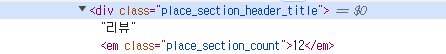

# 합치기 테스트?
https://map.naver.com/p/search/또봉이통닭 도곡점/place/1281659956?c=14.00,0,0,0,dh&placePath=%3Fentry%253Dbmp
https://map.naver.com/p/search/비채/place/1729260818?c=15.00,0,0,0,dh&placePath=%3Fentry%253Dbmp

In [30]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException
import pandas as pd
import time

# ChromeDriver 옵션 설정
options = webdriver.ChromeOptions()
options.add_argument("--disable-gpu")
options.add_argument("--window-size=2560,1440")
options.add_experimental_option("excludeSwitches", ["enable-logging", "enable-automation"])
options.add_argument("--disable-blink-features=AutomationControlled")

# ChromeDriver 초기화
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)

# 네이버 지도 페이지로 이동
driver.get('https://map.naver.com/p/search/또봉이통닭 도곡점/place/1281659956?c=14.00,0,0,0,dh&placePath=%3Fentry%253Dbmp')

# 페이지 로드 대기
WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.ID, "entryIframe")))

try:
    # entryIframe이 로드될 때까지 대기 후 전환
    WebDriverWait(driver, 10).until(EC.frame_to_be_available_and_switch_to_it((By.ID, "entryIframe")))

    # 가게 이름 검색
    store_name_element = WebDriverWait(driver, 15).until(
        EC.presence_of_element_located((By.XPATH, "//*[@id='_title']/div/span[1]"))
    )
    store_name = store_name_element.text

    # 업종 카테고리 검색
    category_element = WebDriverWait(driver, 15).until(
        EC.presence_of_element_located((By.XPATH, "//*[@id='_title']/div/span[2]"))
    )
    category = category_element.text

    # 별점 검색 (없으면 "없음" 출력)
    rating = "없음"
    try:
        rating_element = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.XPATH, "/html/body/div[3]/div/div/div/div[2]/div[1]/div[2]/span[1]"))
        )
        rating_text = rating_element.text
        rating = rating_text.replace("별점", "").strip()
    except (NoSuchElementException, TimeoutException):
        rating = "없음"

    # 방문자 리뷰 검색 (없으면 "없음" 출력)
    try:
        visitor_review_element = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.XPATH, "//*[@id='app-root']/div/div/div/div[2]/div[1]/div[2]/span[2]/a"))
        )
        visitor_review = visitor_review_element.text.split("리뷰")[1].strip()
    except (NoSuchElementException, TimeoutException):
        visitor_review = "없음"

    # 블로그 리뷰 검색 (없으면 "없음" 출력)
    try:
        blog_review_element = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.XPATH, "//*[@id='app-root']/div/div/div/div[2]/div[1]/div[2]/span[3]/a"))
        )
        blog_review = blog_review_element.text.split("리뷰")[1].strip()
    except (NoSuchElementException, TimeoutException):
        blog_review = "없음"

    # 결과 출력
    print(f"가게 이름: {store_name}")
    print(f"업종 카테고리: {category}")
    print(f"별점: {rating}\n")
    print(f"방문자 리뷰: {visitor_review}")
    print(f"블로그 리뷰: {blog_review}\n")


    # '리뷰' 탭 클릭하기
    review_tab_element = WebDriverWait(driver, 15).until(
        EC.element_to_be_clickable((By.XPATH, "//span[text()='리뷰']"))
    )
    review_tab_element.click()
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//*[@id="app-root"]/div/div/div/div[6]/div[3]/div[3]/h2/div[1]/em'))
    )
    print("리뷰 탭 클릭 완료")

    # 리뷰 총 개수 가져오기
    review_count_element = WebDriverWait(driver, 20).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, "#app-root > div > div > div > div:nth-child(6) > div:nth-child(3) > div.place_section.k1QQ5 > h2 > div.place_section_header_title > em.place_section_count"))
    )
    total_reviews = int(review_count_element.text.replace(',', ''))
    print("총 리뷰 수:", total_reviews)
    print('\n')
    total_reviews = min(total_reviews, 1000)  # 최대 1000개의 리뷰로 제한

    reviews = []
    review_text_set = set()
    retry_count = 0
    max_retries = 3

    # '더보기' 버튼이 없어질 때까지 리뷰 수집
    while len(reviews) < total_reviews and retry_count < max_retries:
        review_elements = driver.find_elements(By.XPATH, '//*[@id="app-root"]/div/div/div/div[6]/div[3]/div[3]/div/ul/li')
        loaded_review_count = len(review_elements)
        print(f"로드된 리뷰 개수: {loaded_review_count}, 수집된 리뷰 개수: {len(reviews)}")

        if loaded_review_count > len(reviews):
            retry_count = 0  # 새로운 리뷰가 로드되면 리트라이 카운트 초기화
            for review_element in review_elements[len(reviews):]:
                try:
                    # 리뷰 내용과 날짜를 다양한 XPath로 시도하며 예외 처리
                    review_text = "내용 없음"
                    review_date = "날짜 없음"
                    try:
                        review_text = review_element.find_element(By.XPATH, './div[4]/a').text.strip()
                        review_date = review_element.find_element(By.XPATH, './div[6]/div[2]/div/span[1]/span[2]').text.strip()
                    except NoSuchElementException:
                        try:
                            review_text = review_element.find_element(By.XPATH, './div[4]').text.strip()
                            review_date = review_element.find_element(By.XPATH, './div[6]/div[2]/div/span[1]/span[2]').text.strip()
                        except NoSuchElementException:
                            try:
                                review_text = review_element.find_element(By.XPATH, './div[6]/a').text.strip()
                                review_date = review_element.find_element(By.XPATH, './div[6]/div[2]/div/span[1]/span[2]').text.strip()
                            except NoSuchElementException:
                                review_text = "내용 없음"
                                review_date = "날짜 없음"

                    # 중복 방지 및 저장
                    review_key = (review_text, review_date)
                    if review_key not in review_text_set:
                        reviews.append((review_date, review_text))
                        review_text_set.add(review_key)
                        print(f"리뷰 {len(reviews)}: {review_text} ({review_date})")

                    if len(reviews) >= total_reviews:
                        break
                except NoSuchElementException:
                    continue
        else:
            retry_count += 1
            print("새로운 리뷰가 로드되지 않아 스크롤을 조정하고 재시도합니다...", f"(재시도 {retry_count}/{max_retries})")
            driver.execute_script("window.scrollTo(0, 0);")
            time.sleep(1)
            for scroll_pos in range(500, 8000, 500):
                driver.execute_script(f"window.scrollTo(0, {scroll_pos});")
                time.sleep(1)

        # '더보기' 버튼 클릭
        try:
            bottom_more_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, '//*[@id="app-root"]/div/div/div/div[6]/div[3]/div[3]/div[2]/div/a'))
            )
            driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", bottom_more_button)
            driver.execute_script("arguments[0].click();", bottom_more_button)
            time.sleep(3)
        except (NoSuchElementException, TimeoutException):
            print("'더보기' 버튼이 더 이상 없습니다.")
            break

    print(f"총 {len(reviews)}개의 리뷰를 수집했습니다. (예상 총 리뷰 수: {total_reviews})")

except Exception as e:
    print(f"오류 발생: {e}")

# 수집한 리뷰를 CSV 파일로 저장
if reviews:
    reviews_df = pd.DataFrame(reviews, columns=['Date', 'Review'])
    reviews_df.index = range(1, len(reviews) + 1)
    csv_filename = f"{store_name}_reviews.csv"
    reviews_df.to_csv(csv_filename, index_label="Index", encoding='utf-8-sig')
    print(f"리뷰 데이터가 '{csv_filename}' 파일로 저장되었습니다.")
else:
    print("수집된 리뷰가 없습니다.")


가게 이름: 또봉이통닭 서울도곡점
업종 카테고리: 치킨,닭강정
별점: 방문자 리뷰 7

방문자 리뷰: 5
블로그 리뷰: 없음

리뷰 탭 클릭 완료
총 리뷰 수: 5


로드된 리뷰 개수: 0, 수집된 리뷰 개수: 0
새로운 리뷰가 로드되지 않아 스크롤을 조정하고 재시도합니다... (재시도 1/3)
오류 발생: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=130.0.6723.117)
Stacktrace:
	GetHandleVerifier [0x00C6EBD3+24307]
	(No symbol) [0x00BF8D74]
	(No symbol) [0x00ADC323]
	(No symbol) [0x00ABE00B]
	(No symbol) [0x00B45F6F]
	(No symbol) [0x00B58EC9]
	(No symbol) [0x00B3FC26]
	(No symbol) [0x00B1219C]
	(No symbol) [0x00B1311D]
	GetHandleVerifier [0x00F18D93+2818227]
	GetHandleVerifier [0x00F7542E+3196750]
	GetHandleVerifier [0x00F6D9D2+3165426]
	GetHandleVerifier [0x00D0DA70+675216]
	(No symbol) [0x00C01B3D]
	(No symbol) [0x00BFEA18]
	(No symbol) [0x00BFEBB5]
	(No symbol) [0x00BF1640]
	BaseThreadInitThunk [0x764CFCC9+25]
	RtlGetAppContainerNamedObjectPath [0x7742809E+286]
	RtlGetAppContainerNamedObjectPath [0x7742806E+238]

수집된 리뷰가 없습니다.
